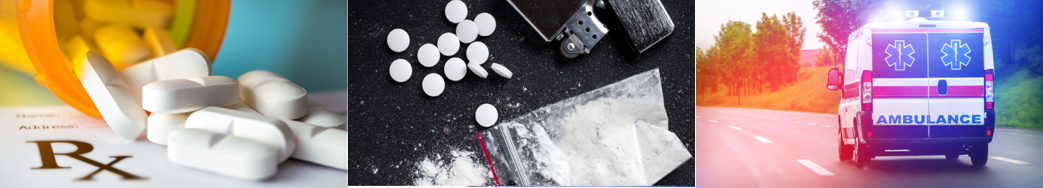

<h1 align=center><font size = 5>Impact os SociEconomic Factors on Opioid Addiction</font></h1>

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction <a name="introduction"></a>

Between 1999 and 2016, more than 630,000 people died from a drug overdose in the United States. The current epidemic of drug overdoses began in the 1990s with overdose deaths involving prescription opioids, driven by dramatic increases in prescribing of opioids for chronic pain.  

We will analyze data for 5 years (2013 to 2017) to understand the **opioid prescription rates of health care providers** based on their speciality and the death rates due to opioid addiction.  

We will aslo study the impact of **Socioeconomic indicators** like poverty rates, population change, unemployment rates, and education levels on opioid addiction



## Data <a name="data"></a>

Based on definition of our problem, data that we need:
* opioid drug prescriptions by doctors by speccialtiy
* socioecnomic data
* United states - State, County and Zipcode data


Following data sources will be needed to extract/generate the required information:
* The Centers for Medicare & Medicaid Services (CMS) has prepared a public data set, the Medicare Part D Opioid Prescriber Summary File
* Scoioecnomic indicators from **https://www.ers.usda.gov/data-products/county-level-data-sets/**  


http://datausa.io/api/data?Geography=01000US:children&measure=Household Income by Race,Household Income by Race Moe&Race=0

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pandas.io.json import json_normalize
import types

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


#!pip install folium
import folium
 
from folium.plugins import MarkerCluster
#from folium.plugins import CirclePattern

from geopy.geocoders import Nominatim 
import requests

import seaborn as sn

# import k-means from clustering stage
from sklearn.cluster import KMeans

import wget

import os

import os.path
from os import path

from sklearn import linear_model
import statsmodels.api as sm

print('Libraries imported.')

Libraries imported.


### Opioid Deaths Dataset

Downloaded the data for opioid deaths from https://opioid.amfar.org/indicator/drugdeaths and stored it in Assessts of IBM Watson

In [2]:

dest_folder  = os.getcwd()
file_name = dest_folder + '\Data\opioid_deaths.csv'
df_opioids = pd.read_csv(file_name)
df_opioids = df_opioids.fillna(0)
 

In [3]:
#Filter data for years 2013 to 2017

df_opioid_deaths = df_opioids.drop(['STATE', 'STATEFP', 'COUNTYFP', 'INDICATOR'],axis=1)

df_opioid_deaths.rename(columns={'STATEABBREVIATION':'State',
                                'YEAR':'Year',
                                'VALUE':'Opioid Deaths'}, inplace=True)

df_opioid_deaths['COUNTY'] = df_opioid_deaths['COUNTY'].str.split(' ').str[0].str.strip()

df_US_opioid_deaths =  df_opioid_deaths[df_opioid_deaths.Year.isin([2013, 2014, 2015, 2016, 2017])]


df_US_opioid_deaths.head()

,Year,Opioid Deaths,State,COUNTY
201,2013,0.0,AL,Calhoun
202,2013,21.0,AL,Etowah
203,2013,16.0,AL,Marshall
204,2013,0.0,AL,Lamar
205,2013,0.0,AL,Lauderdale


In [4]:
def download_file(request, folder, file):
    
    destination = folder + file

    wget.download(request, out=destination) 
    

### Load State, County and Zip data

In [5]:

file_name = dest_folder + '\Data\county_zip.csv'

df_counties = pd.read_csv(file_name,names=['ZIP','COUNTY','STATE','STCOUNTYFP','CLASSFP'],
                             dtype={"ZIP": str},header=1)
df_county_zip = df_counties.drop(['STATE', 'STCOUNTYFP', 'CLASSFP'], axis=1) 

df_county_zip['COUNTY'] = df_county_zip['COUNTY'].str.split(' ').str[0].str.strip()

df_county_zip.head()


,ZIP,COUNTY
0,36006,Autauga
1,36008,Autauga
2,36022,Autauga
3,36051,Autauga
4,36066,Autauga


In [7]:
# Get State Name and State Code

file_name = dest_folder + '\Data\state_abb.json'

if path.exists(file_name):
    print('File Exists: ' + str(path.exists(file_name)))
    with open(file_name, 'r') as f:
            df=json.load(f)
            df_states = pd.json_normalize(df)
            #df_states = pd.read_csv(file_name)
            df_states.rename(columns={'name':'State Name',
                         'abbreviation':'State'}, inplace=True)
else:
    url = 'https://gist.githubusercontent.com/mshafrir/2646763/raw/8303e1d831e89cb8af24a11f2fa77353c317e408/states_titlecase.json'
    download_file(url, file_name)
    with open(file_name, 'r') as f:
            df=json.load(f)
            df_states = pd.json_normalize(df)
            #df_states = pd.read_csv(file_name)
            df_states.rename(columns={'name':'State Name',
                         'abbreviation':'State'}, inplace=True)
df_states.head()

File Exists: True


,State Name,State
0,Alabama,AL
1,Alaska,AK
2,American Samoa,AS
3,Arizona,AZ
4,Arkansas,AR


### Opioid Prescription dataset


This dataset is about Medicare Part D Opioid Prescriber Summary File 2017. https://data.cms.gov/api/views/sakz-a2rp/rows.csv?accessType=DOWNLOAD  
This dataset is about Medicare Part D Opioid Prescriber Summary File 2016. https://data.cms.gov/api/views/6wg9-kwip/rows.csv?accessType=DOWNLOAD  
This dataset is about Medicare Part D Opioid Prescriber Summary File 2015. https://data.cms.gov/api/views/6i2k-7h8p/rows.csv?accessType=DOWNLOAD  
This dataset is about Medicare Part D Opioid Prescriber Summary File 2014. https://data.cms.gov/api/views/e4ka-3ncx/rows.csv?accessType=DOWNLOAD  
This dataset is about Medicare Part D Opioid Prescriber Summary File 2013. https://data.cms.gov/api/views/yb2j-f3fp/rows.csv?accessType=DOWNLOAD  


The **Opioid_data.csv** data set includes details  on the individual opioid prescribing rates of health providers . It includes following fields:  

| Field                     | Description                         |
|---------------------------|-------------------------------------|
| NPI                       | Provider Identification Number      |
| NPPES Provider Last Name  | Provider Last Name                  |
| NPPES Provider First Name | Provider First Name                 |
| NPPES Provider Zip Code   | Provider Zip Code                   |
| NPPES Provider State      | Provider State                      |
| Speciality Description    | Provider Speciality                 |
| Total Claim Count         | Total Claims for by provider                   |
| Opioid Claim Count        | Opioid Claim by provider                  |
| Opioid Prescribing Rate   | Opioid Prescribing Rate             |
| Long Acting Opioid Count  | Long Acting Opioid Claim by provider           |
| Long Acting Opioid Prescribing Rate | Long Acting Opioid Prescribing Rate |
|                           |                                     |


NJ Zip code JSON https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/nj_new_jersey_zip_codes_geo.min.json  



In [8]:
url = 'https://raw.githubusercontent.com/deldersveld/topojson/master/countries/us-states/NJ-34-new-jersey-counties.json'

download_file(url, dest_folder, '/Data/nj_zipcode_geojson')

### Load Opioid Prescription data for 2013 through 2017 from Medicare Part D

#### 2017 Data

In [9]:
### Load Opioid Prescription data for 2017 from Medicare Part D

# Create a dataframe with the loaded cvs file
    
    
file_name = file_name = dest_folder + '\Data\opioid_data_2017.csv'
    
df_opioid_2017 = pd.read_csv(file_name,names=['NPI','NPPES_last_name','NPPES_first_name','NPPES_zip_code','NPPES_state','Speciality_Description','Total_Claim_Count','Opioid_Claim_Count',
                                                           'Opioid_Prescribing_Rate','Long-Acting_Opioid_Claim_Count','Long-Acting_Opioid_Prescribing_Rate'],
                             dtype={"NPPES_zip_code": str, "NPI":str},header=1)

df_opioid_2017 = df_opioid_2017[df_opioid_2017['Long-Acting_Opioid_Claim_Count'].notnull()]
df_opioid_2017 = df_opioid_2017[df_opioid_2017['Long-Acting_Opioid_Claim_Count'] != 0]


df_opioid_2017.head()

,NPI,NPPES_last_name,NPPES_first_name,NPPES_zip_code,NPPES_state,Speciality_Description,Total_Claim_Count,Opioid_Claim_Count,Opioid_Prescribing_Rate,Long-Acting_Opioid_Claim_Count,Long-Acting_Opioid_Prescribing_Rate
0,1003804923,KASTENDIECK,KURT,87505,NM,Family Practice,5342,593.0,11.10,72.0,12.14
20,1912971300,HSU,SHU,93277,CA,Hematology-Oncology,932,96.0,10.30,23.0,23.96
24,1922414408,MILLER,TAMMY,83541,ID,Nurse Practitioner,1516,164.0,10.82,26.0,15.85
29,1942306279,LANGE,NANCY,81501,CO,Nurse Practitioner,1389,107.0,7.70,12.0,11.21
33,1033163605,SNOWDEN OPALAK,LENORE,06484,CT,Internal Medicine,6721,175.0,2.60,35.0,20.00


#### 2106 Data

In [10]:
### Load Opioid Prescription data for 2016 from Medicare Part D

# Create a dataframe with the loaded cvs file

file_name = dest_folder + '\Data\opioid_data_2016.csv'

df_opioid_2016 = pd.read_csv(file_name,names=['NPI','NPPES_last_name','NPPES_first_name','NPPES_zip_code','NPPES_state','Speciality_Description','Total_Claim_Count','Opioid_Claim_Count',
                                                           'Opioid_Prescribing_Rate','Long-Acting_Opioid_Claim_Count','Long-Acting_Opioid_Prescribing_Rate'],
                             dtype={"NPPES_zip_code": str},header=1)

df_opioid_2016 = df_opioid_2016[df_opioid_2016['Long-Acting_Opioid_Claim_Count'].notnull()]
df_opioid_2016 = df_opioid_2016[df_opioid_2016['Long-Acting_Opioid_Claim_Count'] != 0]

df_opioid_2016.head()

,NPI,NPPES_last_name,NPPES_first_name,NPPES_zip_code,NPPES_state,Speciality_Description,Total_Claim_Count,Opioid_Claim_Count,Opioid_Prescribing_Rate,Long-Acting_Opioid_Claim_Count,Long-Acting_Opioid_Prescribing_Rate
0,1003000142,KHALIL,RASHID,43623,OH,Anesthesiology,1733,941.0,54.30,165.0,17.53
7,1003000530,SEMONCHE,AMANDA,18951,PA,Internal Medicine,7047,257.0,3.65,54.0,21.01
20,1003001363,STEVENS,CHARLES,92243,CA,Anesthesiology,2678,1749.0,65.31,586.0,33.50
22,1003001462,WOLSKI,MICHAL,76508,TX,Radiation Oncology,347,66.0,19.02,15.0,22.73
33,1003002312,HOPKINS,PATRICIA,02169,MA,Rheumatology,4634,593.0,12.80,106.0,17.88


#### 2015 Data

In [11]:
### Load Opioid Prescription data for 2015 from Medicare Part D
    
# Create a dataframe with the loaded cvs file

file_name = dest_folder + '\Data\opioid_data_2015.csv'

df_opioid_2015 = pd.read_csv(file_name,names=['NPI','NPPES_last_name','NPPES_first_name','NPPES_zip_code','NPPES_state','Speciality_Description','Total_Claim_Count','Opioid_Claim_Count',
                                                           'Opioid_Prescribing_Rate','Long-Acting_Opioid_Claim_Count','Long-Acting_Opioid_Prescribing_Rate'],
                             dtype={"NPPES_zip_code": str},header=1)

df_opioid_2015 = df_opioid_2015[df_opioid_2015['Long-Acting_Opioid_Claim_Count'].notnull()]
df_opioid_2015 = df_opioid_2015[df_opioid_2015['Long-Acting_Opioid_Claim_Count']!= 0]


df_opioid_2015.head()

,NPI,NPPES_last_name,NPPES_first_name,NPPES_zip_code,NPPES_state,Speciality_Description,Total_Claim_Count,Opioid_Claim_Count,Opioid_Prescribing_Rate,Long-Acting_Opioid_Claim_Count,Long-Acting_Opioid_Prescribing_Rate
0,1003000142,KHALIL,RASHID,43623,OH,Anesthesiology,1757,847.0,48.21,174.0,20.54
8,1003000530,SEMONCHE,AMANDA,18951,PA,Internal Medicine,6401,247.0,3.86,59.0,23.89
21,1003001363,STEVENS,CHARLES,92243,CA,Anesthesiology,2245,1532.0,68.24,543.0,35.44
34,1003002312,HOPKINS,PATRICIA,02169,MA,Internal Medicine,4183,495.0,11.83,99.0,20.00
41,1003002742,LOCKMAN,BRETT,52807,IA,Physical Medicine and Rehabilitation,1675,1157.0,69.07,450.0,38.89


#### 2014 Data

In [12]:
### Load Opioid Prescription data for 2014 from Medicare Part D
   
# Create a dataframe with the loaded cvs file

file_name = dest_folder + '\Data\opioid_data_2014.csv'


df_opioid_2014 = pd.read_csv(file_name,names=['NPI','NPPES_last_name','NPPES_first_name','NPPES_zip_code','NPPES_state','Speciality_Description','Total_Claim_Count','Opioid_Claim_Count',
                                                           'Opioid_Prescribing_Rate','Long-Acting_Opioid_Claim_Count','Long-Acting_Opioid_Prescribing_Rate'],
                             dtype={"NPPES_zip_code": str},header=1)

df_opioid_2014 = df_opioid_2014[df_opioid_2014['Long-Acting_Opioid_Claim_Count'].notnull()]
df_opioid_2014 = df_opioid_2014[df_opioid_2014['Long-Acting_Opioid_Claim_Count']!= 0]


df_opioid_2014.head()

,NPI,NPPES_last_name,NPPES_first_name,NPPES_zip_code,NPPES_state,Speciality_Description,Total_Claim_Count,Opioid_Claim_Count,Opioid_Prescribing_Rate,Long-Acting_Opioid_Claim_Count,Long-Acting_Opioid_Prescribing_Rate
0,1003000142,KHALIL,RASHID,43623,OH,Anesthesiology,1757,847.0,48.21,174.0,20.54
8,1003000530,SEMONCHE,AMANDA,18951,PA,Internal Medicine,6401,247.0,3.86,59.0,23.89
21,1003001363,STEVENS,CHARLES,92243,CA,Anesthesiology,2245,1532.0,68.24,543.0,35.44
34,1003002312,HOPKINS,PATRICIA,02169,MA,Internal Medicine,4183,495.0,11.83,99.0,20.00
41,1003002742,LOCKMAN,BRETT,52807,IA,Physical Medicine and Rehabilitation,1675,1157.0,69.07,450.0,38.89


#### 2013 Data

In [13]:
### Load Opioid Prescription data for 2013 from Medicare Part D
   
# Create a dataframe with the loaded cvs file

file_name = dest_folder + '\Data\opioid_data_2013.csv'


df_opioid_2013 = pd.read_csv(file_name,names=['NPI','NPPES_last_name','NPPES_first_name','NPPES_zip_code','NPPES_state','Speciality_Description','Total_Claim_Count','Opioid_Claim_Count',
                                                           'Opioid_Prescribing_Rate','Long-Acting_Opioid_Claim_Count','Long-Acting_Opioid_Prescribing_Rate'],
                             dtype={"NPPES_zip_code": str},header=1)

df_opioid_2013 = df_opioid_2013[df_opioid_2013['Long-Acting_Opioid_Claim_Count'].notnull()]
df_opioid_2013 = df_opioid_2013[df_opioid_2013['Long-Acting_Opioid_Claim_Count']!= 0]

df_opioid_2013.head()

,NPI,NPPES_last_name,NPPES_first_name,NPPES_zip_code,NPPES_state,Speciality_Description,Total_Claim_Count,Opioid_Claim_Count,Opioid_Prescribing_Rate,Long-Acting_Opioid_Claim_Count,Long-Acting_Opioid_Prescribing_Rate
0,1003000142,KHALIL,RASHID,43623,OH,Anesthesiology,1757,847.0,48.21,174.0,20.54
8,1003000530,SEMONCHE,AMANDA,18951,PA,Internal Medicine,6401,247.0,3.86,59.0,23.89
21,1003001363,STEVENS,CHARLES,92243,CA,Anesthesiology,2245,1532.0,68.24,543.0,35.44
34,1003002312,HOPKINS,PATRICIA,02169,MA,Internal Medicine,4183,495.0,11.83,99.0,20.00
41,1003002742,LOCKMAN,BRETT,52807,IA,Physical Medicine and Rehabilitation,1675,1157.0,69.07,450.0,38.89


In [14]:
df_opioid_2017['YEAR'] = 2017
df_opioid_2016['YEAR'] = 2016
df_opioid_2015['YEAR'] = 2015
df_opioid_2014['YEAR'] = 2014
df_opioid_2013['YEAR'] = 2013

### Clean and extract Opioid Prescription Data

In [17]:
# Concatanate all the dtaframes into a single one

#file_name = dest_folder + '\Data\opioid_total.csv'

#df_opioid_total = pd.read_csv(file_name)

df_opioid_total = pd.concat([df_opioid_2017, df_opioid_2016, df_opioid_2015, df_opioid_2014, df_opioid_2013])\
      .groupby(['NPI','NPPES_last_name','NPPES_first_name','NPPES_zip_code','NPPES_state','Speciality_Description','YEAR'])['Total_Claim_Count','Opioid_Claim_Count','Long-Acting_Opioid_Claim_Count']\
        .sum().reset_index()
df_opioid_US = pd.merge(df_opioid_total,df_county_zip, left_on='NPPES_zip_code',right_on='ZIP')

df_opioid_US.head(10)

#df_opioid_total.head()

<ipython-input-17-f6c86da66623>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_opioid_total = pd.concat([df_opioid_2017, df_opioid_2016, df_opioid_2015, df_opioid_2014, df_opioid_2013])\


,NPI,NPPES_last_name,NPPES_first_name,NPPES_zip_code,NPPES_state,Speciality_Description,YEAR,Total_Claim_Count,Opioid_Claim_Count,Long-Acting_Opioid_Claim_Count,ZIP,COUNTY
0,1003000142,KHALIL,RASHID,43623,OH,Anesthesiology,2013,1757,847.0,174.0,43623,Lucas
1,1003000142,KHALIL,RASHID,43623,OH,Anesthesiology,2014,1757,847.0,174.0,43623,Lucas
2,1003000142,KHALIL,RASHID,43623,OH,Anesthesiology,2015,1757,847.0,174.0,43623,Lucas
3,1003000142,KHALIL,RASHID,43623,OH,Anesthesiology,2016,1733,941.0,165.0,43623,Lucas
4,1003073438,FORQUER,JEFFREY,43623,OH,Radiation Oncology,2013,202,55.0,19.0,43623,Lucas
5,1003073438,FORQUER,JEFFREY,43623,OH,Radiation Oncology,2014,202,55.0,19.0,43623,Lucas
6,1003073438,FORQUER,JEFFREY,43623,OH,Radiation Oncology,2015,202,55.0,19.0,43623,Lucas
7,1013915289,HACKER,TIMOTHY,43623,OH,Internal Medicine,2013,3849,194.0,43.0,43623,Lucas
8,1013915289,HACKER,TIMOTHY,43623,OH,Internal Medicine,2014,3849,194.0,43.0,43623,Lucas
9,1013915289,HACKER,TIMOTHY,43623,OH,Internal Medicine,2015,3849,194.0,43.0,43623,Lucas


In [19]:
# Filter Columns needed for analysis

df_opioid_US_data_c = df_opioid_US.filter(items=['NPI','NPPES_last_name','NPPES_first_name','NPPES_zip_code','NPPES_state','Speciality_Description',
                                                         'YEAR','COUNTY','Total_Claim_Count','Opioid_Claim_Count','Long-Acting_Opioid_Claim_Count'])

df_opioid_US_data_c.rename(columns={'NPPES_zip_code':'ZIP', 'NPPES_state': 'State', 'Long-Acting_Opioid_Claim_Count': 'Opioid Prescription Count',
                                'Speciality_Description':'Speciality','YEAR':'Year'}, inplace=True)

df_opioid_US_data=pd.merge(df_opioid_US_data_c,df_states)
df_opioid_US_data.head()

,NPI,NPPES_last_name,NPPES_first_name,ZIP,State,Speciality,Year,COUNTY,Total_Claim_Count,Opioid_Claim_Count,Opioid Prescription Count,State Name
0,1003000142,KHALIL,RASHID,43623,OH,Anesthesiology,2013,Lucas,1757,847.0,174.0,Ohio
1,1003000142,KHALIL,RASHID,43623,OH,Anesthesiology,2014,Lucas,1757,847.0,174.0,Ohio
2,1003000142,KHALIL,RASHID,43623,OH,Anesthesiology,2015,Lucas,1757,847.0,174.0,Ohio
3,1003000142,KHALIL,RASHID,43623,OH,Anesthesiology,2016,Lucas,1733,941.0,165.0,Ohio
4,1003073438,FORQUER,JEFFREY,43623,OH,Radiation Oncology,2013,Lucas,202,55.0,19.0,Ohio


In [20]:
# Group opioid death data at COUNTY level and filer for NJ

df_opioidDeaths_US_Couty = df_US_opioid_deaths.groupby(['State','COUNTY','Year'])['Opioid Deaths'].sum().reset_index()

df_opioidDeaths_US_Couty.head()

,State,COUNTY,Year,Opioid Deaths
0,AK,Aleutians,2013,0.0
1,AK,Aleutians,2014,0.0
2,AK,Aleutians,2015,0.0
3,AK,Aleutians,2016,0.0
4,AK,Aleutians,2017,0.0


#### Merge opioid Prescription data and opioid death data

In [21]:
# Group opioid prescription data at COUNTY level

df_opioidPres_US_county = df_opioid_US_data.groupby(['State','State Name','COUNTY','Year'])['Total_Claim_Count','Opioid_Claim_Count','Opioid Prescription Count'].sum().reset_index()

df_US_county_data = pd.merge(df_opioidPres_US_county,df_opioidDeaths_US_Couty)

df_US_county_data.head()

<ipython-input-21-f6946211bbbf>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_opioidPres_US_county = df_opioid_US_data.groupby(['State','State Name','COUNTY','Year'])['Total_Claim_Count','Opioid_Claim_Count','Opioid Prescription Count'].sum().reset_index()


,State,State Name,COUNTY,Year,Total_Claim_Count,Opioid_Claim_Count,Opioid Prescription Count,Opioid Deaths
0,AK,Alaska,Anchorage,2013,197026,26911.0,7680.0,49.0
1,AK,Alaska,Anchorage,2014,197026,26911.0,7680.0,58.0
2,AK,Alaska,Anchorage,2015,197026,26911.0,7680.0,59.0
3,AK,Alaska,Anchorage,2016,154395,23451.0,6713.0,52.0
4,AK,Alaska,Anchorage,2017,147256,25215.0,7100.0,71.0


In [22]:
# Data at the State level

df_US_county_data_c = df_US_county_data.filter(items=['State','State Name','COUNTY','Total_Claim_Count','Opioid_Claim_Count','Opioid Prescription Count','Opioid Deaths'])

df_OpiodDeaths = df_US_county_data_c.groupby(['State','State Name'])['Total_Claim_Count','Opioid_Claim_Count','Opioid Prescription Count','Opioid Deaths'].sum().reset_index()

#df_OpiodDeaths = df_OpioidDeaths_county[df_OpioidDeaths_county.State != 'PR']

# Calcualate the rates
df_OpiodDeaths['Opioid Prescription Rate'] = 100/ df_OpiodDeaths['Total_Claim_Count'] * df_OpiodDeaths['Opioid_Claim_Count']
df_OpiodDeaths['Opioid Death Rate'] = 100/ df_OpiodDeaths['Opioid Prescription Count'] * df_OpiodDeaths['Opioid Deaths']

df_US_county_data_c .head(10)

<ipython-input-22-5c97794d1153>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_OpiodDeaths = df_US_county_data_c.groupby(['State','State Name'])['Total_Claim_Count','Opioid_Claim_Count','Opioid Prescription Count','Opioid Deaths'].sum().reset_index()


,State,State Name,COUNTY,Total_Claim_Count,Opioid_Claim_Count,Opioid Prescription Count,Opioid Deaths
0,AK,Alaska,Anchorage,197026,26911.0,7680.0,49.0
1,AK,Alaska,Anchorage,197026,26911.0,7680.0,58.0
2,AK,Alaska,Anchorage,197026,26911.0,7680.0,59.0
3,AK,Alaska,Anchorage,154395,23451.0,6713.0,52.0
4,AK,Alaska,Anchorage,147256,25215.0,7100.0,71.0
5,AK,Alaska,Bethel,10354,838.0,201.0,0.0
6,AK,Alaska,Bethel,10354,838.0,201.0,0.0
7,AK,Alaska,Bethel,10354,838.0,201.0,0.0
8,AK,Alaska,Bethel,9528,1116.0,180.0,0.0
9,AK,Alaska,Bethel,2042,142.0,64.0,0.0


#### Socio Economic Data

In [85]:

file_name = dest_folder + '\Data\state_abb.csv'

if path.exists(file_name):
    print('File Exists: ' + str(path.exists(file_name)))
else:
    url = 'https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv'
    download_file(url, dest_folder, '\Data\state_abb.csv')

File Exists: True


In [86]:
# Get Disablitiy data

file_name = dest_folder + '\Data\SocioEconomicData.csv'

df_socioeconomic = pd.read_csv(file_name, dtype={'Unemployed': int,'Employed':int, 'Homeless':int, 'Population':int,
                                                               'In Poverty':int, 'Not In Poverty':int, 'Depression Count':int, 'Insured':int,
                                                               'Uninsured':int, 'No high school diploma':int,'Bachelor\'s degree or higher':int,
                                                               'Bachelor\'s degree or higher':int,'Median Inome':int})

df_socioeconomic_data = df_socioeconomic.drop('Depression Rate',axis=1)
df_socioeconomic_data.head()


,State,Unemployed,Employed,Homeless,Population,In Poverty,Not in Poverty,Depression Count,Insured,Uninsured,No high school diploma,Bachelor's degree or higher,Median Income
0,AL,1687000,1624000,344,4874747,782000,4038000,324658,4413000,421000,681000,904000,48123
1,AK,167000,243000,216,739795,89000,618000,54671,614000,97000,74000,147000,73181
2,AZ,2185000,2262000,1463,7016270,1108000,5771000,423081,6057000,834000,995000,1560000,56581
3,AR,990000,1009000,450,3004279,471000,2470000,244248,2720000,225000,425000,488000,45869
4,CA,12148000,13237000,35798,39536653,5435000,33708000,2388014,36157000,3031000,6035000,9643000,71805


In [80]:
df_data_analysis = pd.merge(df_OpiodDeaths,df_socioeconomic_data)
df_data_analysis.head()

,State,State Name,Total_Claim_Count,Opioid_Claim_Count,Opioid Prescription Count,Opioid Deaths,Opioid Prescription Rate,Opioid Death Rate,Unemployed,Employed,Homeless,Population,In Poverty,Not in Poverty,Depression Count,Insured,Uninsured,No high school diploma,Bachelor's degree or higher,Median Income
0,AK,Alaska,2397376,284845.0,80420.0,507.0,11.881532,0.630440,167000,243000,216,739795,89000,618000,54671,614000,97000,74000,147000,73181
1,AL,Alabama,109604185,10724897.0,1418972.0,3012.0,9.785116,0.212266,1687000,1624000,344,4874747,782000,4038000,324658,4413000,421000,681000,904000,48123
2,AR,Arkansas,72560331,5805036.0,769923.0,1214.0,8.000289,0.157678,990000,1009000,450,3004279,471000,2470000,244248,2720000,225000,425000,488000,45869
3,AZ,Arizona,60377638,5960465.0,1329658.0,6493.0,9.871974,0.488321,2185000,2262000,1463,7016270,1108000,5771000,423081,6057000,834000,995000,1560000,56581
4,CA,California,315504313,25119456.0,4561179.0,22828.0,7.961684,0.500485,12148000,13237000,35798,39536653,5435000,33708000,2388014,36157000,3031000,6035000,9643000,71805


## Analysis <a name="analysis"></a>

In [81]:
df_data_analysis['Opioid Prescription Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Opioid Prescription Count']
df_data_analysis['Opioid Death Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Opioid Deaths']
df_data_analysis['Unemployment Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Unemployed']
df_data_analysis['Employment Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Employed']
df_data_analysis['Homeless Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Homeless']
df_data_analysis['Poverty Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['In Poverty']
df_data_analysis['Depression Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Depression Count']
df_data_analysis['Insured Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Insured']
df_data_analysis['Uninsured Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Uninsured']
df_data_analysis['HS Dropout Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['No high school diploma']
df_data_analysis['Degree Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Bachelor\'s degree or higher']
''
df_data_analysis_slice = df_data_analysis.filter(items=['State','State Name','Population','Opioid Prescription Rate','Opioid Death Rate', 'Unemployment Rate','Employment Rate',
                                                       'Homeless Rate','Poverty Rate','Depression Rate',
                                                       'Insured Rate','Uninsured Rate','HS Dropout Rate','Degree Rate'])  
df_data_analysis_slice.head()
                                                                                        

,State,State Name,Population,Opioid Prescription Rate,Opioid Death Rate,Unemployment Rate,Employment Rate,Homeless Rate,Poverty Rate,Depression Rate,Insured Rate,Uninsured Rate,HS Dropout Rate,Degree Rate
0,AK,Alaska,739795,10.870579,0.068532,22.573821,32.846937,0.029197,12.030360,7.390020,82.995965,13.111740,10.002771,19.870369
1,AL,Alabama,4874747,29.108629,0.061788,34.606924,33.314549,0.007057,16.041858,6.659997,90.527775,8.636346,13.969956,18.544552
2,AR,Arkansas,3004279,25.627547,0.040409,32.952998,33.585429,0.014979,15.677638,8.130004,90.537530,7.489318,14.146489,16.243498
3,AZ,Arizona,7016270,18.951067,0.092542,31.141903,32.239352,0.020852,15.791867,6.029999,86.327921,11.886658,14.181324,22.234036
4,CA,California,39536653,11.536584,0.057739,30.725919,33.480325,0.090544,13.746738,6.040000,91.451848,7.666304,15.264317,24.390026


#### Add Latitude and Logitute data for the States

In [88]:
file_name = dest_folder + '\Data\state_geo'

if path.exists(file_name):
    print('File Exists: ' + str(path.exists(file_name)))
else:
    url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json'
    download_file(url, dest_folder, '\Data\state_geo')

File Exists: True


In [90]:

file_name = dest_folder + '\Data\county_geo'

if path.exists(file_name):
    print('File Exists: ' + str(path.exists(file_name)))
else:
    print('Downloading File: ' + str(path.exists(file_name)))
    url = 'https://raw.githubusercontent.com/python-visualization/folium/master/tests/us-counties.json'
    download_file(url, dest_folder, '\Data\county_geo')

File Exists: True


In [92]:
file_name = dest_folder + '\Data\statelatlong.csv'

df_US_latlon = pd.read_csv(file_name)
#df_US_latlon.head(10)

df_data_analysis_US = pd.merge(df_data_analysis_slice, df_US_latlon)

df_data_analysis_US.head(10)

,State,State Name,Population,Opioid Prescription Rate,Opioid Death Rate,Unemployment Rate,Employment Rate,Homeless Rate,Poverty Rate,Depression Rate,Insured Rate,Uninsured Rate,HS Dropout Rate,Degree Rate,Latitude,Longitude,City
0,AK,Alaska,739795,10.870579,0.068532,22.573821,32.846937,0.029197,12.030360,7.390020,82.995965,13.111740,10.002771,19.870369,61.302501,-158.775020,Alaska
1,AL,Alabama,4874747,29.108629,0.061788,34.606924,33.314549,0.007057,16.041858,6.659997,90.527775,8.636346,13.969956,18.544552,32.601011,-86.680736,Alabama
2,AR,Arkansas,3004279,25.627547,0.040409,32.952998,33.585429,0.014979,15.677638,8.130004,90.537530,7.489318,14.146489,16.243498,34.751928,-92.131378,Arkansas
3,AZ,Arizona,7016270,18.951067,0.092542,31.141903,32.239352,0.020852,15.791867,6.029999,86.327921,11.886658,14.181324,22.234036,34.168219,-111.930907,Arizona
4,CA,California,39536653,11.536584,0.057739,30.725919,33.480325,0.090544,13.746738,6.040000,91.451848,7.666304,15.264317,24.390026,37.271875,-119.270415,California
5,CO,Colorado,5607154,23.945980,0.071962,24.433072,38.682726,0.037916,8.328646,7.619998,88.832944,9.416542,8.346480,30.817773,38.997934,-105.550567,Colorado
6,CT,Connecticut,3588184,16.315858,0.112815,25.249541,36.425111,0.010785,9.782107,6.840006,93.417729,6.103366,11.398524,30.990607,41.518784,-72.757507,Connecticut
7,DC,District of Columbia,693972,5.741010,0.129976,25.937646,43.661704,0.211824,16.138980,7.279977,93.663721,5.043431,7.781294,47.120057,38.899349,-77.014567,District of Columbia
8,DE,Delaware,961939,25.839372,0.121941,30.043485,36.280887,0.012787,11.435237,6.519956,89.818585,8.732362,11.955020,21.103209,39.145251,-75.418921,Delaware
9,FL,Florida,20984400,19.647958,0.084320,32.914927,35.168983,0.023422,12.671318,6.119999,86.159242,11.751587,11.227388,23.160062,27.975728,-83.833017,Florida


#### Opioid Prescription Rate vs Opioid Death Rates

#### Correlatioin

In [93]:
df_data_analysis_slice.corr()

,Population,Opioid Prescription Rate,Opioid Death Rate,Unemployment Rate,Employment Rate,Homeless Rate,Poverty Rate,Depression Rate,Insured Rate,Uninsured Rate,HS Dropout Rate,Degree Rate
Population,1.000000,-0.268572,-0.009793,0.198068,-0.101216,0.073486,0.068420,-0.430229,-0.187167,0.187256,0.336167,0.039057
Opioid Prescription Rate,-0.268572,1.000000,-0.109901,0.088359,-0.107946,-0.419653,0.057685,0.348548,0.129018,-0.052236,0.028533,-0.312123
Opioid Death Rate,-0.009793,-0.109901,1.000000,0.340232,-0.026436,0.108908,0.011621,0.182606,0.250715,-0.231552,0.063476,0.257345
Unemployment Rate,0.198068,0.088359,0.340232,1.000000,-0.596736,-0.009631,0.683542,-0.124884,-0.121834,0.178563,0.694314,-0.359285
Employment Rate,-0.101216,-0.107946,-0.026436,-0.596736,1.000000,0.330139,-0.488393,-0.011870,0.377885,-0.384916,-0.642731,0.718236
Homeless Rate,0.073486,-0.419653,0.108908,-0.009631,0.330139,1.000000,0.074966,-0.088047,0.215511,-0.240115,-0.211063,0.582860
Poverty Rate,0.068420,0.057685,0.011621,0.683542,-0.488393,0.074966,1.000000,-0.147312,-0.324268,0.394115,0.686196,-0.398641
Depression Rate,-0.430229,0.348548,0.182606,-0.124884,-0.011870,-0.088047,-0.147312,1.000000,0.244009,-0.233049,-0.150882,0.025671
Insured Rate,-0.187167,0.129018,0.250715,-0.121834,0.377885,0.215511,-0.324268,0.244009,1.000000,-0.955781,-0.357354,0.401917
Uninsured Rate,0.187256,-0.052236,-0.231552,0.178563,-0.384916,-0.240115,0.394115,-0.233049,-0.955781,1.000000,0.412058,-0.423027


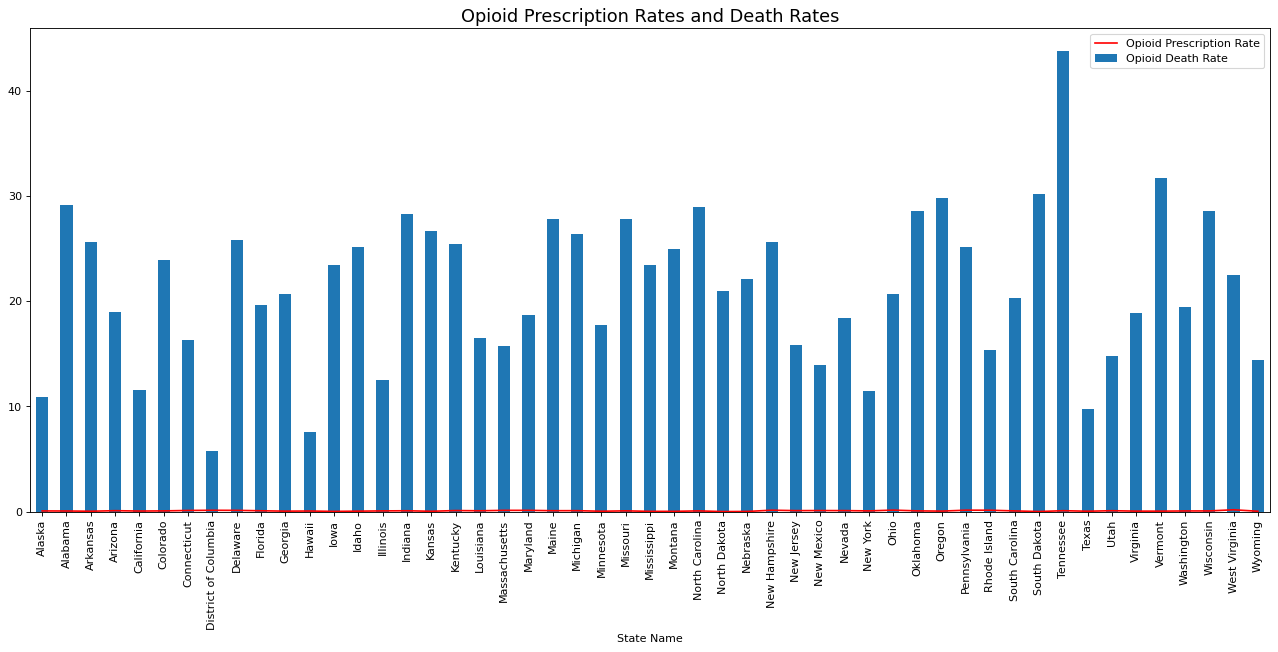

In [94]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()

#plt.figure()
#fig = plt.figure(figsize=(3,10)

df_data_analysis_US.plot(kind='bar',x='State Name', figsize=(20,8), y='Opioid Prescription Rate', ax=ax)
df_data_analysis_US.plot(kind='line',x='State Name', y='Opioid Death Rate', color='red',ax=ax)

ax.set_title('Opioid Prescription Rates and Death Rates', fontsize=16)
plt.rcParams.update({'font.size': 14})
plt.xticks(rotation='vertical')

plt.show()

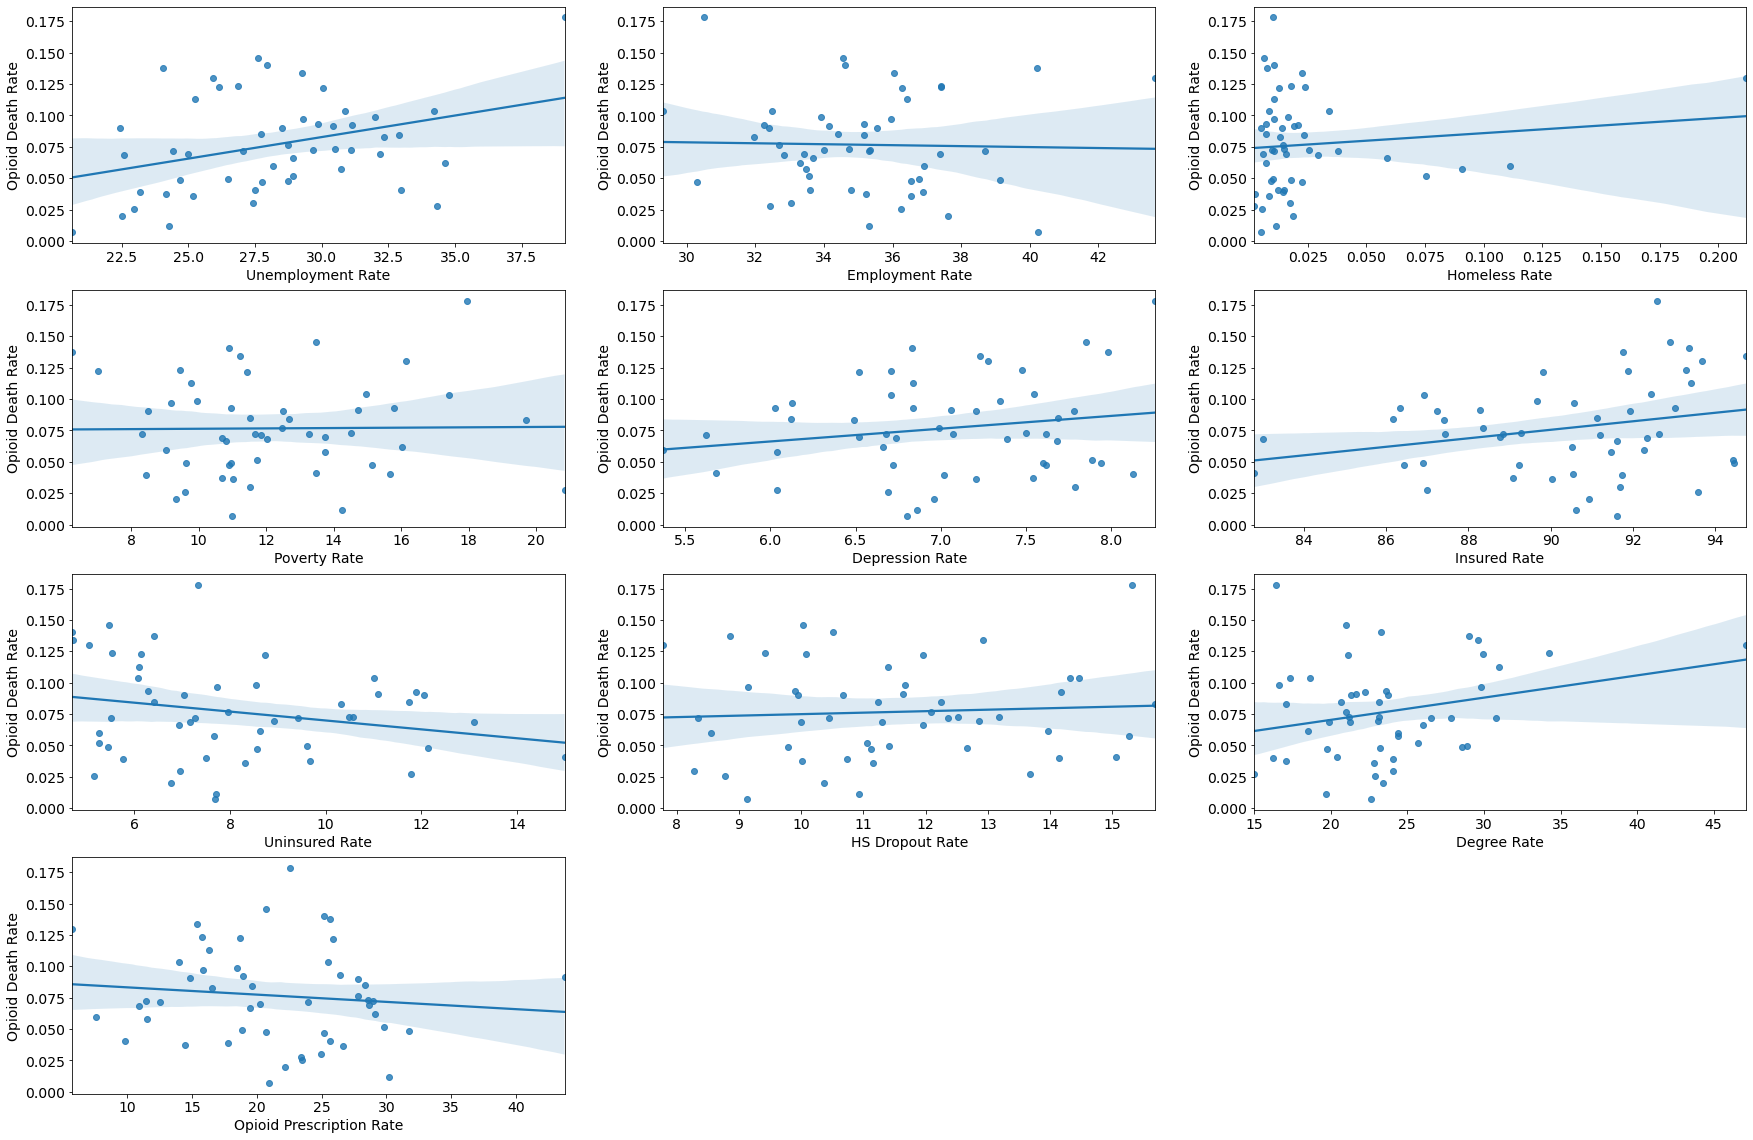

In [95]:
#==============================================================================
#  Plots on two different Figures and sets the size of the figures
#==============================================================================

# figure size = (width,height)
f1 = plt.figure(figsize=(30,20))
#f2 = plt.figure(figsize=(30,10))

#------------------------------------------------------------------------------
#  Figure 1 with 6 plots
#------------------------------------------------------------------------------

# plot one
# Plot column labeled Unemploymnet Rate
# subplot(4 Rows, 3 Columns, First subplot,)
ax1 = f1.add_subplot(4,3,1)
ax1 = sn.regplot(x="Unemployment Rate", y="Opioid Death Rate", data=df_data_analysis_US)

# plot two
# plot column labeled Employment Rate
# subplot(4 Rows, 3 Columns, Second subplot)
ax2 = f1.add_subplot(4,3,2)
ax2 = sn.regplot(x="Employment Rate", y="Opioid Death Rate", data=df_data_analysis_US)

# plot three
# plot column Homeless Rate
# subplot(4 Rows, 3 Columns, Third subplot)
ax3 = f1.add_subplot(4,3,3)
ax3 = sn.regplot(x="Homeless Rate", y="Opioid Death Rate", data=df_data_analysis_US)

# plot four
# plot column labeled Poverty Rate
# subplot(4 Rows, 3 Columns, Fourth subplot)
ax4 = f1.add_subplot(4,3,4)
ax4 = sn.regplot(x="Poverty Rate", y="Opioid Death Rate", data=df_data_analysis_US)

# plot five
# plot column labeled Depression Rate
# subplot(4 Rows, 3 Columns, Fifth subplot)
ax5 = f1.add_subplot(4,3,5)
ax5 = sn.regplot(x="Depression Rate", y="Opioid Death Rate", data=df_data_analysis_US)

# plot six
# plot column labeled Insured Rate
# subplot(4 Rows, 3 Columns, Sixth subplot)
ax6 = f1.add_subplot(4,3,6)
ax6 = sn.regplot(x="Insured Rate", y="Opioid Death Rate", data=df_data_analysis_US)

# plot seven
# Curve 1: plot column labeled Uninsured Rate
# subplot(4 Rows, 3 Columns, Seventh subplot)
ax7 = f1.add_subplot(4,3,7)
ax7 = sn.regplot(x="Uninsured Rate", y="Opioid Death Rate", data=df_data_analysis_US)

# plot eight
# Curve 1: plot column labeled HS Dropout Rate
# subplot(4 Rows, 3 Columns, Eight subplot)
ax8 = f1.add_subplot(4,3,8)
ax8 = sn.regplot(x="HS Dropout Rate", y="Opioid Death Rate", data=df_data_analysis_US)

# plot nine
# Curve 1: plot column labeled Degree Rate
# subplot(4 Rows, 3 Columns, Nitnth subplot)
ax9 = f1.add_subplot(4,3,9)
ax9 = sn.regplot(x="Degree Rate", y="Opioid Death Rate", data=df_data_analysis_US)

# plot ten
# Curve 1: plot column labeled Degree Rate
# subplot(4 Rows, 3 Columns, Tenth subplot)
ax10 = f1.add_subplot(4,3,10)
ax10 = sn.regplot(x="Opioid Prescription Rate", y="Opioid Death Rate", data=df_data_analysis_US)


plt.show()


#### Plot the data on US Map

In [97]:
COORDINATES = (37, -102)
MAX_COUNT = len(df_data_analysis_US)

file_name = dest_folder + '\Data\state_geo'

map_opioid = folium.Map(location=COORDINATES, zoom_start=5)

map_opioid.choropleth(
 geo_data=file_name,
 name='choropleth',
 data=df_data_analysis_US,
 columns=['State', 'Opioid Prescription Rate'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.9,
 line_opacity=0.5,
 legend_name='Opioid Prescription Rate vs Death Rate'
)
folium.LayerControl().add_to(map_opioid)

for each in df_data_analysis_US[0:MAX_COUNT].iterrows():
   folium.Circle(
      location=[each[1]['Latitude'], each[1]['Longitude']],
      popup=each[1]['State'],
      radius=each[1]['Opioid Death Rate']*1000000,
      color='red',
      fill=True,
      fill_color='red'
   ).add_to(map_opioid)

map_opioid

map_opioid.save('US_Opioid_2017.html')

#### Top 5 States - Opioid Death Rates

In [98]:
df_data_analysis_sorted = df_data_analysis_US.sort_values('Opioid Death Rate', ascending=False)
df_data_analysis_sorted.head()

,State,State Name,Population,Opioid Prescription Rate,Opioid Death Rate,Unemployment Rate,Employment Rate,Homeless Rate,Poverty Rate,Depression Rate,Insured Rate,Uninsured Rate,HS Dropout Rate,Degree Rate,Latitude,Longitude,City
49,WV,West Virginia,1815857,22.521983,0.178153,39.099995,30.509010,0.010353,17.952956,8.260012,92.573369,7.324365,15.309576,16.410984,38.920171,-80.181691,West Virginia
35,OH,Ohio,11658609,20.672621,0.145729,27.619075,34.558154,0.006219,13.492176,7.850002,92.901306,5.472351,10.035503,20.997359,40.190362,-82.669252,Ohio
38,PA,Pennsylvania,12805537,25.183669,0.140439,27.948847,34.602219,0.010714,10.901534,6.829999,93.365862,4.701091,10.518887,23.263374,40.994593,-77.604698,Pennsylvania
30,NH,New Hampshire,1342795,25.631016,0.137474,24.054305,40.214627,0.007447,6.255609,7.979997,91.748927,6.404552,8.862112,29.043897,44.001231,-71.579923,New Hampshire
39,RI,Rhode Island,1059639,15.411853,0.134008,29.255246,36.050013,0.022649,11.230240,7.230009,94.749250,4.718588,12.928931,29.632733,41.582728,-71.506451,Rhode Island


#### Bottom 5 States - Opioid Death Rates

In [99]:
df_data_analysis_sorted.tail()

,State,State Name,Population,Opioid Prescription Rate,Opioid Death Rate,Unemployment Rate,Employment Rate,Homeless Rate,Poverty Rate,Depression Rate,Insured Rate,Uninsured Rate,HS Dropout Rate,Degree Rate,Latitude,Longitude,City
25,MS,Mississippi,2984100,23.422070,0.027613,34.315204,32.438591,0.002044,20.843806,6.040012,86.994404,11.795851,13.672464,14.979391,32.585106,-89.877220,Mississippi
12,IA,Iowa,3145711,23.488331,0.025654,22.983675,36.239820,0.005404,9.600373,6.689998,93.587745,5.149869,8.773851,22.856518,41.938317,-93.389798,Iowa
29,NE,Nebraska,1920076,22.150009,0.020155,22.499109,37.602678,0.018801,9.322548,6.959985,90.933901,6.770565,10.364173,23.436572,41.500819,-99.680902,Nebraska
41,SD,South Dakota,869666,30.205044,0.011729,24.262188,35.300909,0.011614,14.258347,6.859990,90.609498,7.704107,10.923734,19.662721,44.212699,-100.247164,South Dakota
28,ND,North Dakota,755393,20.952405,0.007016,20.651502,40.243952,0.004898,10.987658,6.800037,91.607944,7.678123,9.134318,22.637223,47.467882,-100.302266,North Dakota


#### Regression Analysis - Opioid Death Rate

In [106]:
X = df_data_analysis_US[['Unemployment Rate', 'Employment Rate', 'Homeless Rate', 'Poverty Rate', 'Depression Rate', 'Insured Rate', 'Uninsured Rate', 'HS Dropout Rate', 'Degree Rate']]
Y = df_data_analysis_US[['Opioid Death Rate']]

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:      Opioid Death Rate   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     2.922
Date:                Thu, 24 Sep 2020   Prob (F-statistic):            0.00905
Time:                        13:19:32   Log-Likelihood:                 107.63
No. Observations:                  51   AIC:                            -195.3
Df Residuals:                      41   BIC:                            -175.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.2485      0.56

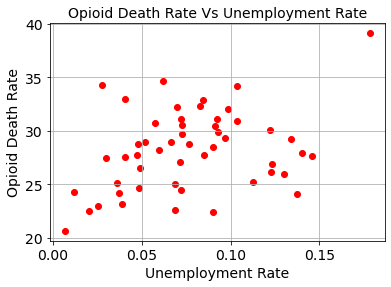

In [112]:
plt.scatter(df_data_analysis_US['Opioid Death Rate'].astype(float),df_data_analysis_US['Unemployment Rate'].astype(float), color = 'r')
plt.title('Opioid Death Rate Vs Unemployment Rate', fontsize=14)
plt.xlabel('Unemployment Rate', fontsize=14)
plt.ylabel('Opioid Death Rate', fontsize=14)
plt.grid(True)
plt.show()

#### Regression Analysis - Opioid Prescription Rate

In [113]:
X = df_data_analysis_US[['Unemployment Rate', 'Employment Rate', 'Homeless Rate', 'Poverty Rate', 'Depression Rate', 'Insured Rate', 'Uninsured Rate', 'HS Dropout Rate', 'Degree Rate']]
Y = df_data_analysis_US[['Opioid Prescription Rate']]

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                               OLS Regression Results                               
Dep. Variable:     Opioid Prescription Rate   R-squared:                       0.410
Model:                                  OLS   Adj. R-squared:                  0.280
Method:                       Least Squares   F-statistic:                     3.163
Date:                      Thu, 24 Sep 2020   Prob (F-statistic):            0.00546
Time:                              14:30:17   Log-Likelihood:                -159.09
No. Observations:                        51   AIC:                             338.2
Df Residuals:                            41   BIC:                             357.5
Df Model:                                 9                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

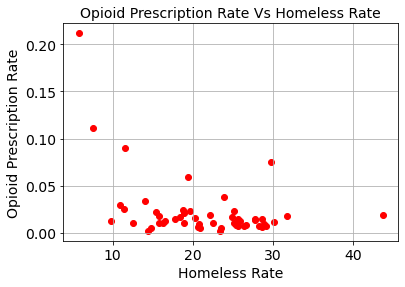

In [115]:
plt.scatter(df_data_analysis_US['Opioid Prescription Rate'].astype(float),df_data_analysis_US['Homeless Rate'].astype(float), color = 'r')
plt.title('Opioid Prescription Rate Vs Homeless Rate', fontsize=14)
plt.xlabel('Homeless Rate', fontsize=14)
plt.ylabel('Opioid Prescription Rate', fontsize=14)
plt.grid(True)
plt.show()

## Results and Discussion <a name="results"></a>

When you compare **West Virginia** the state with the **highest opioid death rate**  with the **North Dakota** the state with the **lowest opioid death rate** one notices that the socio-economic factors <br>

<table>
    <tr><td></td><td><b>West Virginia</b></td><td><b>North Dakota</b></td></tr>
    <tr><td><b>Unemployment rate</b></td><td>39.099</td><td>20.651</td></tr> 
    <tr><td><b>Employment rate</b></td><td>30.509</td><td>40.243</td></tr>
    <tr><td><b>Homeless rate</b></td><td>0.0103</td><td>0.0048</td></tr> 
    <tr><td><b>Poverty rate</b></td><td>17.952</td><td>10.987</td></tr>
    <tr><td><b>Depression rate</b></td><td>8.260</td><td>6.800</td></tr>
    <tr><td><b>Insured rate</b></td><td>92.573</td><td>91.607</td></tr>
    <tr><td><b>Uninsured rate</b></td><td>7.324</td><td>7.678</td></tr>
    <tr><td><b>HS Dropout Rate rate</b></td><td>15.309</td><td>9.134</td></tr>
    <tr><td><b>Degree rate</b></td><td>16.410</td><td>22.637</td></tr>
    <tr><td><b>Opioid Prescription rate</b></td><td>3.733</td><td>3.428</td></tr>
</table>

have an impact on the opioid death rate.The state with the highest opioid death rate has the highest enemploymnet rate, homless rate, por=verty rate, depression rate, High School Dropout rate and Opioid Prescripi=tion rate.

Further analysis of the linear dependencies on the two variables - opioid death rate and individual socio-economic factors - results shown below

<table>
    <tr><td></td><td><b>Pearson Correlation Coefficient</b></td><td><b>P-value</b></td></tr>
    <tr><td><b>Unemployment Rate vs Opioid Death Rate</b></td><td>0.28010068903143265</td><td>0.04650549259363219</td></tr> 
    <tr><td><b>Employment Rate vs Opioid Death Rate</b></td><td>0.10425512143745068</td><td>0.46657670297060405</td></tr>
    <tr><td><b>Homeless Rate vs Opioid Death Rate</b></td><td>0.16816118599253874</td><td>0.23817466877861332</td></tr> 
    <tr><td><b>Poverty Rate vs Opioid Death Rat</b></td><td>0.007456071165732117</td><td>0.9585863588975125</td></tr>
    <tr><td><b>Depression Rate vs Opioid Death Rate</b></td><td>0.1427173514015973</td><td>0.3177635047469663</td></tr>
    <tr><td><b>Insured Rate vs Opioid Death Rate</b></td><td>0.30178300346351755</td><td>0.03138253740135453</td></tr>
    <tr><td><b>Uninsured Rate vs Opioid Death Rate</b></td><td>-0.3017031801271633</td><td>0.031429597696551494</td></tr>
    <tr><td><b>HS Dropout Rate vs Opioid Death Ratee</b></td><td>-0.02998984442396571</td><td>0.8345202835700284</td></tr>
    <tr><td><b>Degree Rate vs Opioid Death Rate</b></td><td>0.1427173514015973</td><td>0.3177635047469663</td></tr>
    <tr><td><b>Opioid Prescription Rate vs Opioid Death Rate</b></td><td>-0.10350138706867021</td><td>0.4698224383106909</td></tr>
</table>

indicate moderate evidence that the correlation is significant on the impact of **unemployment and insurance rate** on opioid death rate 